## 5-3. Quantum Approximate Optimazation Algorithm (QAOA)

### Overview

In this section, we learn the Quantum Approximate Optimazation Algorithm (QAOA), which is considered one of the NISQ algorithms. QAOA, like quantum annealing, is an algorithm for solving combinatorial optimization problems.

### Problem setting
In QAOA, for a $n$ digit bit string $z = z_{1}z_{2}\cdots z_{n} \: (z_i =0,1)$, we consider a problem of finding $z$ such that cost function $C(z) = \sum_\alpha C_\alpha(z)$ is minimized.
 $C_\alpha(z)$ is some kind of function that takes a bit string $z$ as an argument, and here we should especially consider terms such as Ising model-like $C_\alpha(z) = z_i\cdot z_j$.

To solve this minimization problem, we use a $n$**-bit quantum system**. And using $\beta = (\beta^{(1)}, \cdots \beta^{(p)}), \gamma = (\gamma^{(1)}, and  \cdots \gamma^{(p)})$ as parameter, consider the following quantum state.

\begin{align}
&|s\rangle = |+\rangle^{\otimes n} = \frac{1}{2^{n/2}} \sum_{z=0}^{2^{n}-1} |z\rangle, \\
&|\beta, \gamma \rangle = U_X(\beta^{(p)}) U_C(\gamma^{(p)}) \cdots U_X(\beta^{(1)}) U_C(\gamma^{(1)}) |s\rangle. 
\end{align}

Here, $|+\rangle=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ is the eigenstate of operator $X$, $X|+\rangle=|+\rangle$. Also, $U_C(\gamma), U_X(\beta)$ are defined as follows.

$$
U_C(\gamma^{(i)}) = e^{-i\gamma^{(i)} C(Z)} = \prod_{\alpha} e^{-i\gamma^{(i)} C_{\alpha}(Z)}, \\
U_X(\beta^{(i)}) = e^{-i\beta^{(i)} \sum_{j=1}^n X_j} = \prod_{j =1}^n e^{-i\beta^{(i)} X_j}.
$$

Knowledge of quantum annealing is required to explain the states $|\beta, \gamma \rangle$ and the meaning of these operators. For the time being, if you just use QAOA, you should accept it as such and use it.
(Note that $C(Z)$ is obtained by substituting the Pauli operator $Z_1\cdots Z_n$ for the input of the function $C(z)$ that takes a bit string as an argument.)

and QAOA algorithm tries to find the answer to the original optimization problem by searching for $\beta,\gamma$ which minimize $F(\beta, \gamma) = \langle{\bf \gamma, \,\beta}|C(Z)|{\bf \gamma, \,\beta}\rangle$

### QAOA Algorithm Steps
The concrete procedure of the QAOA algorithm is as follows.

1. Create a superposition state $|s\rangle = |+\rangle^{\otimes n}$ on a quantum computer.
2. Depending on the parameters $\beta, \gamma$, multiply the quantum state by $U_C(\gamma^{(i)}),U_X(\beta^{(i)})$ to get the state $|\beta, \gamma \rangle$.
3. Measure $\langle \beta, \gamma |C(Z)|\beta, \gamma \rangle$ using a quantum computer.
4. On classical computers, update the parameters $\beta, \gamma$ so that $\langle \beta, \gamma |C(Z)|\beta, \gamma \rangle$ becomes smaller.
5. Repeat steps 1-4 to get the best $\beta^*, \gamma^*$.
6. For the state $|\beta^*, \gamma^* \rangle$, perform multiple projection measurements in the direction of $z$, take **obtained measurement result** $z_1\cdots z_n$ ** (which looks good) **as the solution to the original optimization problem.** (Note: the measurement result $z_1\cdots z_n$ is the classical bit)

It's a little confusing, so let's check it while implementing a specific example.

### Implementation: Solve the Maxcut problem with QAOA

As a specific example, we use the Maxcut problem.
[Maxcut problem](https://en.wikipedia.org/wiki/Maximum_cut) is the problem to find a cut that maximizes the number of edges split when a graph with $n$ vertices (for example, the figure below) is split into two.

![maxcut-example](figs/5/maxcut_example.png)
(Figure source: Wikipedia [Maximum cut](https://en.wikipedia.org/wiki/Maximum_cut))

To reduce this problem to an optimization problem that can be handled by QAOA, we do the following.
If you divide the vertices into two groups, give +1 to the vertices belonging to one group and -1 to the other group. Then, the cost function

$$
C(z) = -\frac{1}{2} \sum_{\text{vertices connected by edges}i,j} ( 1 - z_i z_j)
$$

represents (number of edges divided by grouping) $\times (-1)$.
Therefore, if we find a bit string $z=z_1\cdots z_n$ that minimizes $C(z)$, it meand that we have found a way to divide vertices that maximizes the number of split edges.

In the following, let's solve the maxcut problem for a rectangle (a figure with four vertices).

![maxcut](figs/5/maxcut_4nodes.png)


In this case, $C(Z)$ is

$$
\begin{align}
C(Z) &= -\frac{1}{2}(1-Z_{0}Z_{1})-\frac{1}{2}(1-Z_{1}Z_{2})-\frac{1}{2}(1-Z_{2}Z_{3})-\frac{1}{2}(1-Z_{3}Z_{1})\\
&=\frac{1}{2}(Z_{0}Z_{1}+Z_{1}Z_{2}+Z_{2}Z_{3}+Z_{3}Z_{1}) - 2
\end{align}
$$


The second term is a constant. Therefore,

$$
C(Z) = \frac{1}{2}(Z_{0}Z_{1}+Z_{1}Z_{2}+Z_{2}Z_{3}+Z_{3}Z_{1}) 
$$


#### $p=1$ case

Let's implement the case when $p=1$. Here, $|\beta, \gamma \rangle = U_X(\beta^{(1)}) U_C(\gamma^{(1)}) |s\rangle$ 

When we implement $U_C(\gamma^{(1)}) = \prod_{i=0}^3 e^{-i\gamma^{(1)} Z_i Z_{i+1} }$ , we use the following relation used in chapter 4-2

$$
e^{-i \delta Z_i Z_{i+1}}　= \operatorname{CNOT}_{i,i+1} \cdot e^{-i\delta Z_{i+1}} \cdot \operatorname{CNOT}_{i,i+1}.
$$

When you convert this into a matrix and calculate, you will find that the above equation is correct.

Next, we will compose $|\beta, \gamma \rangle$, measure  $\langle \beta, \gamma | C(Z) |\beta, \gamma \rangle$ and implement the process to minimize it.

In [ ]:
## Run only if you are in Google Colaboratory or in a local environment where Qulacs is not installed
!pip install qulacs

## Run only in Google Colaboratory or (Linux or Mac) jupyter notebook environment
## Qulacs errors will be output normally.
!pip3 install wurlitzer
%load_ext wurlitzer

In [1]:
#Import required libraries
from qulacs import QuantumState, QuantumCircuit, Observable, PauliOperator
from qulacs.gate import H, CNOT, RX, RZ
from scipy.optimize import minimize
import numpy as np

## number of vertices
n = 4 

## Define C(Z) as qulacs.Observable
cost_observable = Observable(n) 
for i in range(n):
    cost_observable.add_operator( PauliOperator("Z {:} Z {:}".format(i, (i+1)%n), 0.5) )

# A function to add U_C(gamma) to a circuit 
def add_U_C(circuit, gamma):
    for i in range(n):
        j = (i+1) % n
        circuit.add_CNOT_gate(i, j)
        circuit.add_gate(RZ(j, -2*gamma)) ## With qulacs, RZ(theta)=e^{i*theta/2*Z}
        circuit.add_CNOT_gate(i, j)
    return circuit
    
# A function to add U_X(beta) to a circuit
def add_U_X(circuit, beta):
    for i in range(n):
        circuit.add_gate(RX(i, -2*beta))
    return circuit

# a fuction to prepare |beta, gamma> in the case of p=1 and return <beta, gamma| C(Z) |beta, gamma>
# x = [beta, gamma]
def QAOA_output_onelayer(x): 
    beta, gamma = x

    circuit = QuantumCircuit(n)
    ## to create superposition, apply Hadamard gate
    for i in range(n):
        circuit.add_H_gate(i)
    ##apply  U_C, U_X
    circuit =  add_U_C(circuit, gamma)
    circuit =  add_U_X(circuit, beta)

    ## prepare |beta, gamma>
    state = QuantumState(n)
    state.set_zero_state()                     
    circuit.update_quantum_state(state)
    return cost_observable.get_expectation_value(state)                 

## initial value
x0 = np.array( [0.1, 0.1 ])

## minimize with scipy.minimize
result = minimize(QAOA_output_onelayer, x0, options={'maxiter':500}, method='powell')
print(result.fun) # value after optimization
print(result.x) # (beta, gamma) after optimization

-0.999999999499185
[1.17809152 0.39269362]


We got the minimum value -1 and corresponding $\beta^{(1)}, \gamma^{(1)}$.
What value do we get from projective measurement of $|\beta, \gamma\rangle$ in z axis ?

In [2]:
# prepare |beta, gamma> using optimized best, gamma 
beta_opt, gamma_opt = result.x

circuit = QuantumCircuit(n)
## to create superposition, apply Hadamard gate
for i in range(n):
    circuit.add_H_gate(i)
##apply  U_C, U_X
circuit =  add_U_C(circuit, gamma_opt)
circuit =  add_U_X(circuit, beta_opt)

## prepare |beta, gamma>
state = QuantumState(n)
state.set_zero_state()                     
circuit.update_quantum_state(state)

## Find the of each component of the state vector = probability distribution when observed in the z direction. (Square of the absolute value observation probability)
probs = np.abs(state.get_vector())**2
print(probs)

[0.01562503 0.01562568 0.01562568 0.0781236  0.01562568 0.26562503
 0.0781236  0.01562568 0.01562568 0.0781236  0.26562503 0.01562568
 0.0781236  0.01562568 0.01562568 0.01562503]


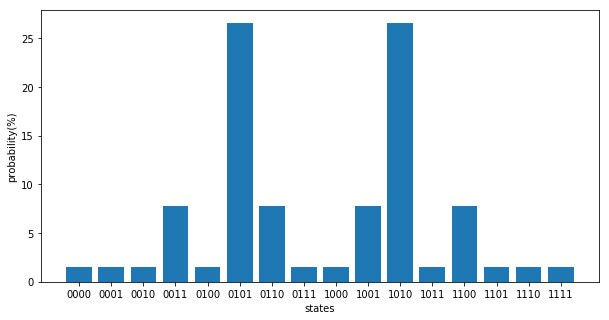

In [5]:
# plot
import matplotlib.pyplot as plt
%matplotlib inline

## a bit string which can be acquired from z axis projective measurement 
z_basis = [format(i,"b").zfill(n) for i in range(probs.size)]

plt.figure(figsize=(10, 5))
plt.xlabel("states")
plt.ylabel("probability(%)")
plt.bar(z_basis, probs*100)
plt.show()

In other words, it was found that there is a high probability that `0101` or `1010` will be measured when projective measurement is performed in the $z$ direction. These bit strings mean that vertices 1 and 3, and vertices 2 and 4 belong to the same group, so they represent the following partition:

![maxcut-p-1](figs/5/maxcut_result_p1.png)

Here, the number of edges crossed by the curve that divides the figure is 4, which is the maximum number of edges that pass when dividing this figure.

Therefore, if we perform projection measurement on the optimized $|\beta, \gamma\rangle$, perform a certain number of measurement, and adopt a bit string with a high measurement probability, we can solve the optimization problem $C(z)$ solution is obtained.
However, remember that the value of the optimized cost function $\langle \beta, \gamma | C(Z) |\beta, \gamma \rangle$ was -1. $\langle 0101 | C(Z) |0101 \rangle = \langle 1010 | C(Z) |1010 \rangle = -2$, so we are not getting the correct value for the cost function! This is because the variational state $|\beta, \gamma \rangle$ did not have sufficient expressiveness, and the true solution $|0101\rangle, |1010\rangle$ could not be expressed.

So let's see how the results change when the circuit is more complicated and $p=2$.

*By the way, if I measure $|\beta, \gamma\rangle$ 100 times to obtain 100 bit strings $z$, and calculate $C(z)$ for each of them using a classical computer, such a problem may not occur.

#### $p=2$ case

-1.9999996223652372
[1.01150163 1.11872823 0.45213228 0.55937865]
[1.10913271e-15 9.96406007e-09 9.96406007e-09 2.72762241e-08
 9.96406007e-09 4.99999906e-01 2.72762241e-08 9.96406007e-09
 9.96406007e-09 2.72762241e-08 4.99999906e-01 9.96406007e-09
 2.72762241e-08 9.96406007e-09 9.96406007e-09 1.10913271e-15]


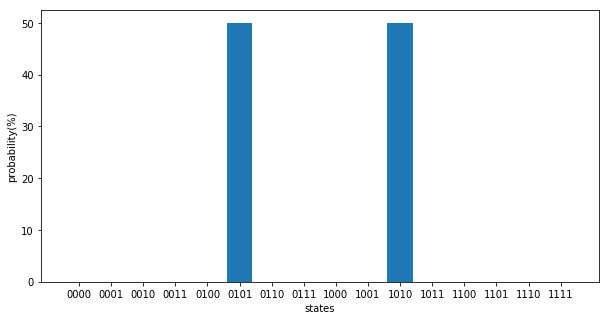

In [8]:
#Import required libraries
from qulacs import QuantumState, QuantumCircuit, Observable, PauliOperator
from qulacs.gate import H, CNOT, RX, RZ
from scipy.optimize import minimize
import numpy as np

## number of vertices
n = 4 

## define C(Z) as qulacs.Observable
cost_observable = Observable(n) 
for i in range(n):
    cost_observable.add_operator( PauliOperator("Z {:} Z {:}".format(i, (i+1)%n), 0.5) )

# a function to add U_C(gamma) to a circuit
def add_U_C(circuit, gamma):
    for i in range(n):
        j = (i+1) % n
        circuit.add_CNOT_gate(i, j)
        circuit.add_gate(RZ(j, -2*gamma)) ## With qulacs, RZ(theta)=e^{i*theta/2*Z}
        circuit.add_CNOT_gate(i, j)
    return circuit
    
# A function to add U_X(beta) to a circuit
def add_U_X(circuit, beta):
    for i in range(n):
        circuit.add_gate(RX(i, -2*beta))
    return circuit

# a function to |beta, gamma> in the case of p=2  and return  <beta, gamma| C(Z) |beta, gamma>
# x = [beta0, beta1, gamma0, gamma1]
def QAOA_output_twolayer(x): 
    beta0, beta1, gamma0, gamma1 = x

    circuit = QuantumCircuit(n)
    ## to create superposition, apply Hadamard gate
    for i in range(n):
        circuit.add_H_gate(i)
    ##apply  U_C, U_X
    circuit =  add_U_C(circuit, gamma0)
    circuit =  add_U_X(circuit, beta0)
    circuit =  add_U_C(circuit, gamma1)
    circuit =  add_U_X(circuit, beta1)

    ## prepare |beta, gamma>
    state = QuantumState(n)
    state.set_zero_state()                     
    circuit.update_quantum_state(state)
    return cost_observable.get_expectation_value(state)                 

## initial value
x0 = np.array( [0.1, 0.1, 0.2, 0.3 ])

## minimize with scipy.minimize
result = minimize(QAOA_output_twolayer, x0, options={'maxiter':500}, method='powell')
print(result.fun) # value after optimization
print(result.x) # [beta0, beta1, gamma0, gamma1] after optimization

## Check the probability distribution when measuring the state after optimization
beta0, beta1, gamma0, gamma1 = result.x

circuit = QuantumCircuit(n)
 ## to create superposition, apply Hadamard gate
for i in range(n):
    circuit.add_H_gate(i)
## apply U_C, U_X
circuit =  add_U_C(circuit, gamma0)
circuit =  add_U_X(circuit, beta0)
circuit =  add_U_C(circuit, gamma1)
circuit =  add_U_X(circuit, beta1)

## prepare |beta, gamma>
state = QuantumState(n)
state.set_zero_state()                     
circuit.update_quantum_state(state)

##  Square of the absolute value observation probability
probs = np.abs(state.get_vector())**2
print(probs)

## a bit string which can be acquired from z axis projective measurement 
z_basis = [format(i,"b").zfill(n) for i in range(probs.size)]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.xlabel("states")
plt.ylabel("probability(%)")
plt.bar(z_basis, probs*100)
plt.show()

Compared to the case of $p=1$, it can be seen that the probability of obtaining the true solutions $|0101\rangle, |1010\rangle$ is overwhelmingly high. Also, the value of the cost function is correctly approaching -2.

Thus, when using QAOA, it will be necessary to pay attention to the size of the complexity $p$ of the variational quantum circuit.

### Reference

[1] E. Farhi, J. Goldstone, and S. Gutmann, “A Quantum Approximate Optimization Algorithm”, [arXiv:1411.4028](https://arxiv.org/abs/1411.4028) (2014).

[2] Eddie Farhi: A Quantum Approximate Optimization Algorithm, https://www.youtube.com/watch?v=J8y0VhnISi8